In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df=pd.read_csv('/content/cars.csv')
df.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [79]:
df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In [80]:
for clm in ['car name','brand','country','price','engine_capacity','cylinder','horse_power','top_speed','seats']:
    print(f'Name: {clm} dtype: {df[clm].dtype}\n')
    print(f'{df[clm].value_counts()}\n')
    print(('-' * 80) + '\n\n')

Name: car name dtype: object

car name
Mercedes-Benz C-Class 2022 C 300                          10
Fiat 500e 2021 La Prima                                    7
Porsche 911 2021 Carrera S Cabriolet                       7
Porsche 911 2021 Carrera 4S                                7
Kia Rio Sedan 2021 1.6L MPI                                7
                                                          ..
Jaguar F-Type Convertible 2021 2.0T R-Dynamic (300 PS)     1
Hyundai Kona 2021 1.6L T-GDI GLS Premium (AWD)             1
Chevrolet Trax 2021 1.8L Premier AWD                       1
Jaguar XF 2021 3.0 V6 SC R Sport                           1
Lamborghini Aventador Ultimae 2022 LP 780-4                1
Name: count, Length: 2546, dtype: int64

--------------------------------------------------------------------------------


Name: brand dtype: object

brand
mercedes-benz    560
audi             398
bmw              394
toyota           378
ford             323
                ... 
tata   

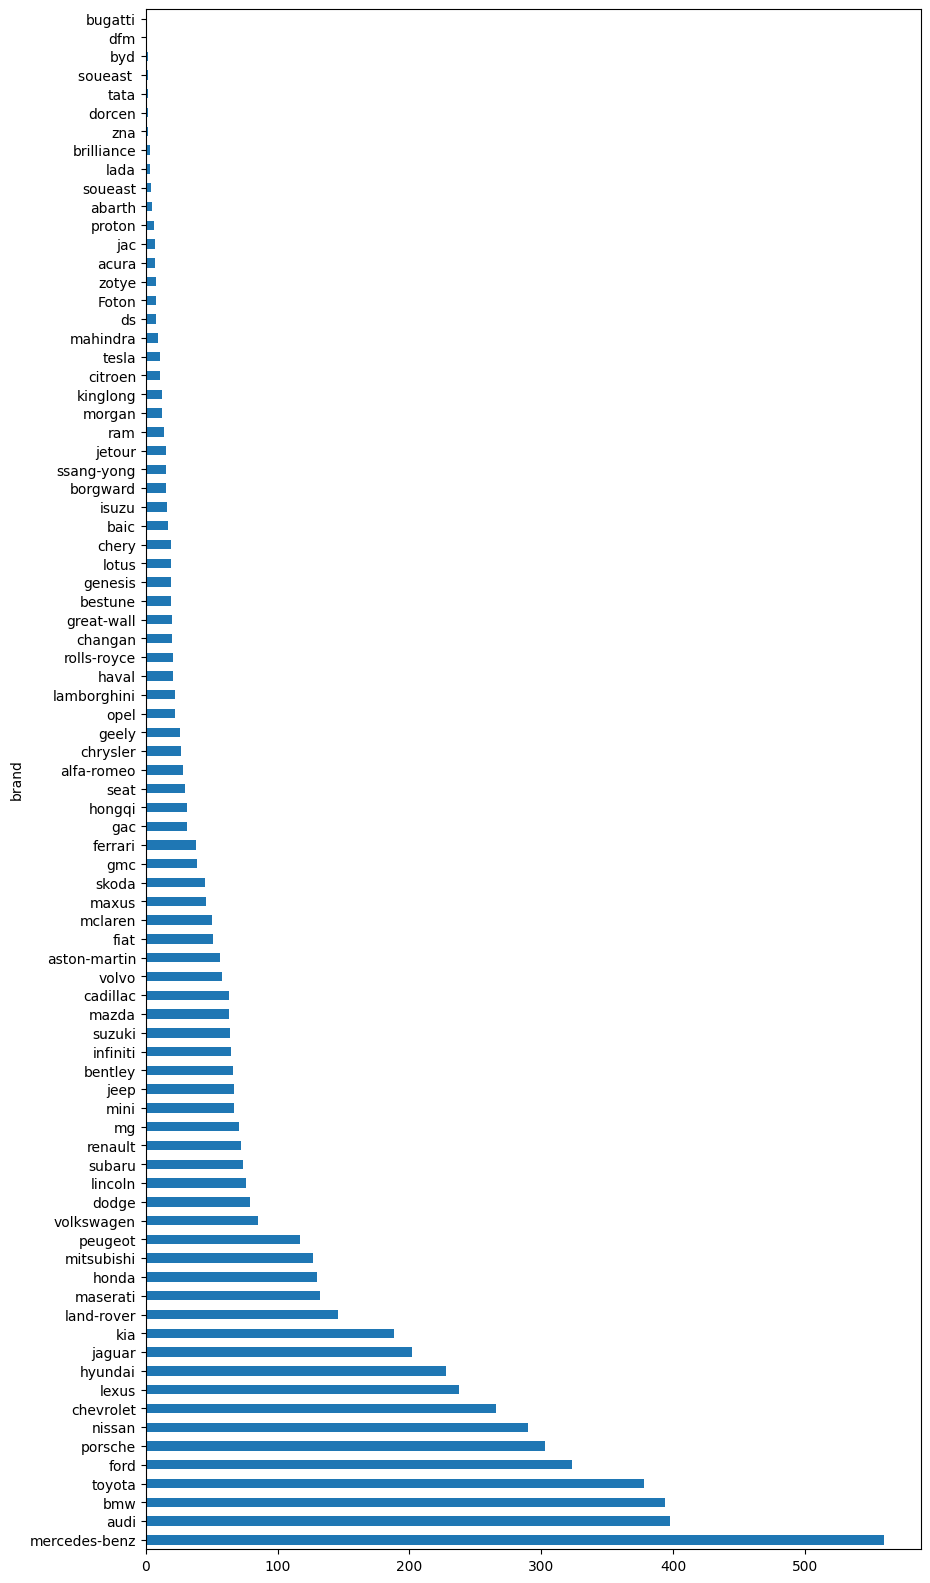

In [81]:
df['brand'].value_counts().plot.barh(figsize=(10,20));

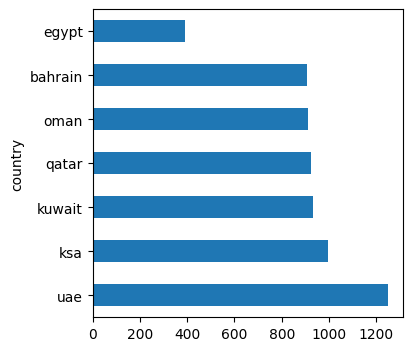

In [82]:
df['country'].value_counts().plot.barh(figsize=(4,4));

In [83]:
# This are some value I found symple by searching in the web

LIMIT_HOURSE_POWER = 1_500.0
LIMIT_KMH = 530.0
LIMIT_ENGINE_CAPACITY = 8.4
LIMIT_CYLINDER_NR = 16.0

In [84]:
def add_columns_by_function(df, clm, function, new_clms):
    new_data = df[clm].apply(function).apply(pd.Series)
    new_data.columns = new_clms
    df = pd.concat([df, new_data], axis=1)
    return df

In [85]:
def apply_price_adj(price):
    try:
        # Extract the currency code (first 3 characters)
        c = price[:3]
        # Extract the price string (everything after the currency code)
        price_str = price[4:].replace(',', '')  # Remove thousand separators

        # Convert price to float
        p = float(price_str)

        pe = p # Euros
        pd = p # Dollar
        # Currency conversion rates
        conversion_rates = {
            'AED': (0.24, 0.27),
            'KWD': (2.93, 3.28),
            'OMR': (2.32, 2.60),
            'BHD': (2.37, 2.65),
            'QAR': (0.27, 0.25),
            'SAR': (0.24, 0.27),
            'EGP': (0.018, 0.021)
        }

        # Adjust price based on currency
        if c in conversion_rates:
            pe, pd = [p * rate for rate in conversion_rates[c]]

        return [p, c, pe, pd]

    except (ValueError, IndexError) as e:
        # Return error values in a consistent format
        return ['0', '0', '0', '0']

In [86]:
df_upd = df

# adjust price
df_upd = add_columns_by_function(df_upd, 'price', apply_price_adj, ['price_country', 'price_currency', 'price_euro', 'price_dollar'])

# adjust engine_capacity
df_upd['engine_capacity_float'] = pd.to_numeric(df_upd['engine_capacity'], errors='coerce')
df_upd['engine_capacity_l'] = np.where(df_upd['engine_capacity_float'] <= LIMIT_ENGINE_CAPACITY, df_upd['engine_capacity_float'],  '0')

# adjust cylinder
df_upd['cylinder_float'] = pd.to_numeric(df_upd['cylinder'], errors='coerce')
df_upd['cylinder_nr'] = np.where(df_upd['cylinder_float'] <= LIMIT_CYLINDER_NR, df_upd['cylinder_float'], '0')
df_upd['is_eletric'] = np.where((df_upd['cylinder'] == 'N/A, Electric') | (df_upd['engine_capacity_l'] == 0), True, False)
# adjust horse_power
df_upd['horse_power_float'] = pd.to_numeric(df_upd['horse_power'], errors='coerce')
df_upd['horse_power_cv'] = np.where(df_upd['horse_power_float'] <= LIMIT_HOURSE_POWER, df_upd['horse_power_float'], '0')

# adjust top_speed
df_upd['top_speed_float'] = pd.to_numeric(df_upd['top_speed'], errors='coerce')
df_upd['top_speed_kmh'] = np.where(df_upd['top_speed_float'] <= LIMIT_KMH, df_upd['top_speed_float'], '0')
# adjust country
mapping = {
    'uae':'United Arab Emirates',
    'ksa':'Saudi Arabia',
    'kuwait':'Kuwait',
    'qatar':'Qatar',
    'oman':'Oman',
    'bahrain': 'Bahrain',
    'egypt': 'Egypt'
}
df_upd = df_upd.replace(mapping)

df_upd.drop(['seats', 'engine_capacity_float', 'cylinder_float', 'horse_power_float', 'top_speed_float'], axis=1, inplace=True)

df_upd


,car name,price,engine_capacity,cylinder,horse_power,top_speed,brand,country,price_country,price_currency,price_euro,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,fiat,Saudi Arabia,0,0,0,0,0.0,0,True,0,0
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,peugeot,Saudi Arabia,140575.0,SAR,33738.0,37955.25,2.0,4.0,False,180.0,0
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,suzuki,Saudi Arabia,98785.0,SAR,23708.4,26671.95,1.5,4.0,False,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,ford,Saudi Arabia,198000.0,SAR,47520.0,53460.0,2.3,4.0,False,420.0,0
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,honda,Saudi Arabia,0,0,0,0,1.8,4.0,False,140.0,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,DISCONTINUED,6.8,8,505,296,bentley,United Arab Emirates,0,0,0,0,6.8,8.0,False,505.0,296.0
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,"AED 1,766,100",4.0,8,25,800,ferrari,United Arab Emirates,1766100.0,AED,423864.0,476847.0,4.0,8.0,False,25.0,0
6305,Rolls Royce Wraith 2021 6.6L Base,"AED 1,400,000",6.6,12,624,250,rolls-royce,United Arab Emirates,1400000.0,AED,336000.0,378000.0,6.6,12.0,False,624.0,250.0
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,"AED 1,650,000",6.5,NaN,740,350,lamborghini,United Arab Emirates,1650000.0,AED,396000.0,445500.0,6.5,0,False,740.0,350.0


In [87]:
dataset = df_upd

dataset.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,brand,country,price_country,price_currency,price_euro,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh
count,6308,6308,6308,5684,6308,6308,6308,6308,6308,6308,6308,6308,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,7,2514,8,3214,3221,53,9,2,325,155
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,mercedes-benz,United Arab Emirates,0,0,0,0,2.0,4.0,False,150.0,250.0
freq,10,437,1241,2856,162,1100,560,1248,1329,1329,1329,1329,1241,2856,6201,162,1100


In [89]:
dataset.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,brand,country,price_country,price_currency,price_euro,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,fiat,Saudi Arabia,0,0,0,0,0.0,0,True,0,0
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,peugeot,Saudi Arabia,140575.0,SAR,33738.0,37955.25,2.0,4.0,False,180.0,0
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,suzuki,Saudi Arabia,98785.0,SAR,23708.4,26671.95,1.5,4.0,False,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,ford,Saudi Arabia,198000.0,SAR,47520.0,53460.0,2.3,4.0,False,420.0,0
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,honda,Saudi Arabia,0,0,0,0,1.8,4.0,False,140.0,190.0


In [90]:
import pandas as pd
from google.colab import files


selected_columns = ['car name', 'price_country', 'price_currency', 'price_dollar', 'engine_capacity_l', 'cylinder_nr', 'is_eletric', 'horse_power_cv' , 'top_speed_kmh' , 'brand' , 'country']
new_df = dataset[selected_columns]

new_df.to_csv('new_dataset.csv', index=False)

# Step 4: Download the new dataset
files.download('/content/new_dataset.csv')
new_df.head()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,car name,price_country,price_currency,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh,brand,country
0,Fiat 500e 2021 La Prima,0,0,0,0.0,0,True,0,0,fiat,Saudi Arabia
1,Peugeot Traveller 2021 L3 VIP,140575.0,SAR,37955.25,2.0,4.0,False,180.0,0,peugeot,Saudi Arabia
2,Suzuki Jimny 2021 1.5L Automatic,98785.0,SAR,26671.95,1.5,4.0,False,102.0,145.0,suzuki,Saudi Arabia
3,Ford Bronco 2021 2.3T Big Bend,198000.0,SAR,53460.0,2.3,4.0,False,420.0,0,ford,Saudi Arabia
4,Honda HR-V 2021 1.8 i-VTEC LX,0,0,0,1.8,4.0,False,140.0,190.0,honda,Saudi Arabia


In [91]:
#View the shape of the dataset
new_df.shape

(6308, 11)

In [92]:
#View the column names
new_df.columns.unique()

Index(['car name', 'price_country', 'price_currency', 'price_dollar',
       'engine_capacity_l', 'cylinder_nr', 'is_eletric', 'horse_power_cv',
       'top_speed_kmh', 'brand', 'country'],
      dtype='object')

In [93]:
cols = new_df.columns
def Unique_Values():
    for i in np.arange(0,len(cols)):
        print('There are {} nos of unique values in {} column out of {}'.format(new_df[cols[i]].nunique(), cols[i], len(df)))
Unique_Values()

There are 2546 nos of unique values in car name column out of 6308
There are 2514 nos of unique values in price_country column out of 6308
There are 8 nos of unique values in price_currency column out of 6308
There are 3221 nos of unique values in price_dollar column out of 6308
There are 53 nos of unique values in engine_capacity_l column out of 6308
There are 9 nos of unique values in cylinder_nr column out of 6308
There are 2 nos of unique values in is_eletric column out of 6308
There are 325 nos of unique values in horse_power_cv column out of 6308
There are 155 nos of unique values in top_speed_kmh column out of 6308
There are 82 nos of unique values in brand column out of 6308
There are 7 nos of unique values in country column out of 6308


In [70]:
new_df.head()

,car name,price_country,price_currency,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh,brand,country
0,Fiat 500e 2021 La Prima,0,0,0,0.0,0,True,0,0,fiat,Saudi Arabia
1,Peugeot Traveller 2021 L3 VIP,140575.0,SAR,37955.25,2.0,4.0,False,180.0,0,peugeot,Saudi Arabia
2,Suzuki Jimny 2021 1.5L Automatic,98785.0,SAR,26671.95,1.5,4.0,False,102.0,145.0,suzuki,Saudi Arabia
3,Ford Bronco 2021 2.3T Big Bend,198000.0,SAR,53460.0,2.3,4.0,False,420.0,0,ford,Saudi Arabia
4,Honda HR-V 2021 1.8 i-VTEC LX,0,0,0,1.8,4.0,False,140.0,190.0,honda,Saudi Arabia


In [94]:
# Drop rows where any numerical column contains the value 0
numerical_columns = new_df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    new_df = new_df[new_df[column] != 0]

# Drop rows where any categorical column contains the value '0'
categorical_columns = new_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    new_df = new_df[new_df[column] != '0']

# Display updated missing value counts and the first few rows
print(new_df.isnull().sum())
new_df.shape
new_df.head()

car name             0
price_country        0
price_currency       0
price_dollar         0
engine_capacity_l    0
cylinder_nr          0
is_eletric           0
horse_power_cv       0
top_speed_kmh        0
brand                0
country              0
dtype: int64


,car name,price_country,price_currency,price_dollar,engine_capacity_l,cylinder_nr,is_eletric,horse_power_cv,top_speed_kmh,brand,country
2,Suzuki Jimny 2021 1.5L Automatic,98785.0,SAR,26671.95,1.5,4.0,False,102.0,145.0,suzuki,Saudi Arabia
5,Honda HR-V 2021 1.8 i-VTEC EX,95335.0,SAR,25740.45,1.8,4.0,False,140.0,190.0,honda,Saudi Arabia
6,Peugeot Expert 2021 Van L3 A/T,82845.0,SAR,22368.15,2.0,4.0,False,120.0,170.0,peugeot,Saudi Arabia
7,Peugeot Expert 2021 Van L3 M/T,76545.0,SAR,20667.15,2.0,4.0,False,120.0,170.0,peugeot,Saudi Arabia
8,Renault Koleos 2021 2.5L LE (4WD),116900.0,SAR,31563.0,2.5,4.0,False,170.0,199.0,renault,Saudi Arabia


In [22]:
new_df.shape

(3904, 11)

Training set: (3784, 10) (3784,)
Validation set: (1262, 10) (1262,)
Test set: (1262, 10) (1262,)


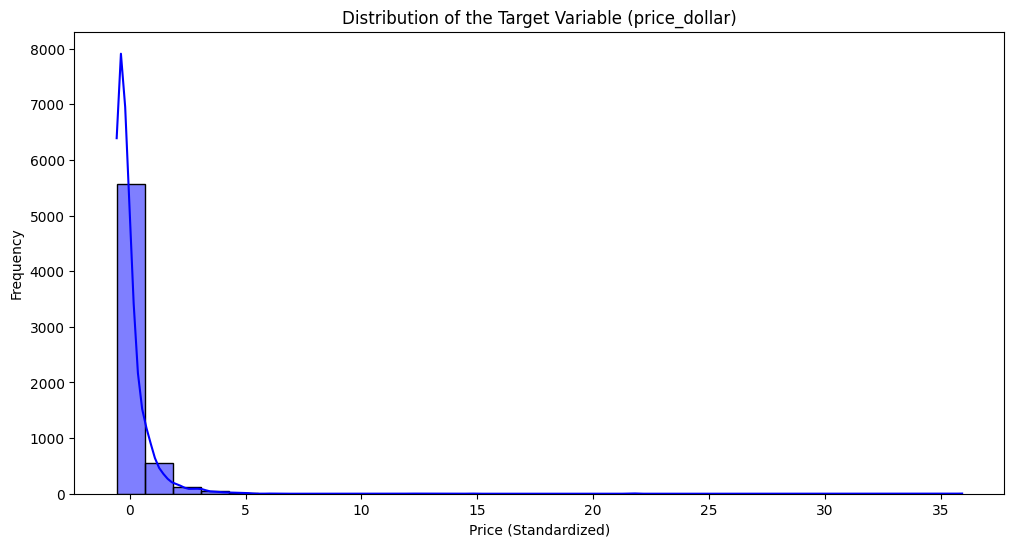

<ipython-input-95-cbc4145e3eb6>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=split_labels, y=split_sizes, palette='viridis')


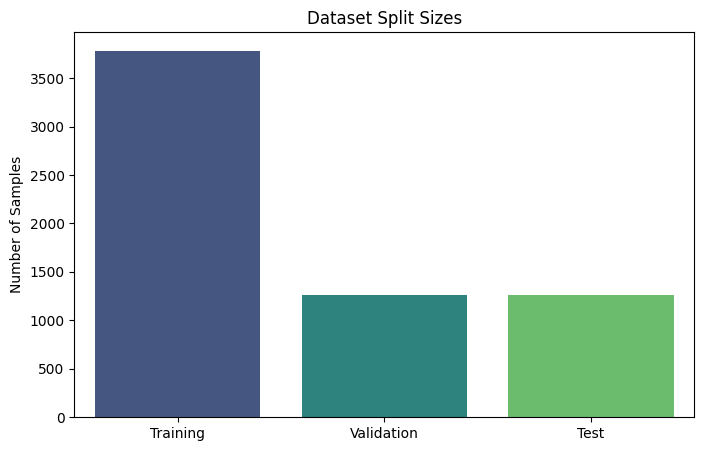

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df2 = pd.read_csv('/content/new_dataset.csv')
df2.head()

# Encode categorical features
categorical_cols = df2.select_dtypes(include=['object']).columns
label_enc = LabelEncoder()
for col in categorical_cols:
    df2[col] = label_enc.fit_transform(df2[col])

# Normalize or Standardize Numerical Features
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df2[numeric_cols] = scaler.fit_transform(df2[numeric_cols])

# Split Dataset into Training, Validation, and Test Sets (60-20-20 split)
X = df2.drop(columns=['price_dollar'])  # Use 'price_dollar' as the consistent target column
y = df2['price_dollar']

# Perform the 60-20-20 train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check shapes of splits
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Visualization

# 1. Distribution of Target Variable
plt.figure(figsize=(12, 6))
sns.histplot(y, kde=True, bins=30, color='blue')
plt.title("Distribution of the Target Variable (price_dollar)")
plt.xlabel("Price (Standardized)")
plt.ylabel("Frequency")
plt.show()

# 2. Bar Plot of Data Split Sizes
split_sizes = [len(y_train), len(y_val), len(y_test)]
split_labels = ['Training', 'Validation', 'Test']
plt.figure(figsize=(8, 5))
sns.barplot(x=split_labels, y=split_sizes, palette='viridis')
plt.title("Dataset Split Sizes")
plt.ylabel("Number of Samples")
plt.show()


# 2.1. Linear Models: Linear Regression, LASSO, and Ridge Regression
# Import Required Libraries

In [96]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Define and Fit Linear Regression, LASSO, and Ridge Models

Linear Regression MSE: 0.29257306021185714
LASSO Regression MSE: 0.30349443108747737
Ridge Regression MSE: 0.2924468787772562


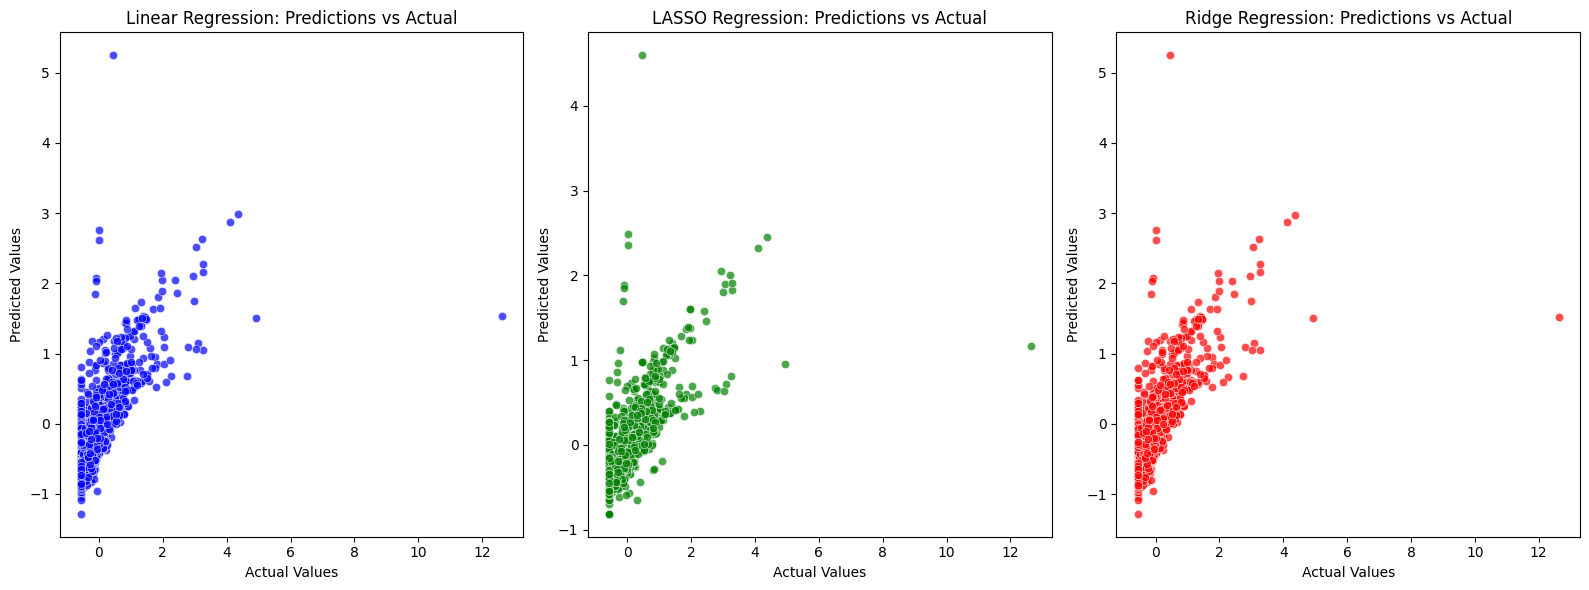

<ipython-input-97-12e0e6061437>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mse_values, palette="viridis")


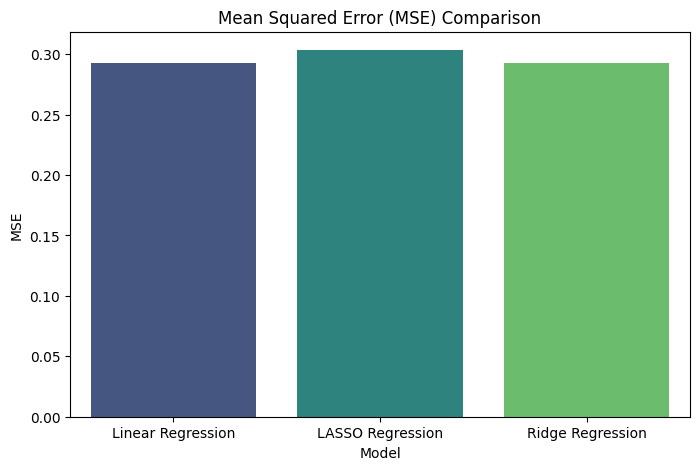

In [97]:
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Drop columns with all NaN values and update column lists
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
X_train = X_train.drop(columns=cols_with_all_nan)
X_val = X_val.drop(columns=cols_with_all_nan)

# Identify numeric and categorical columns after dropping NaN columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Impute numeric columns if they exist
if len(numeric_cols) > 0:
    numeric_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
    X_val[numeric_cols] = numeric_imputer.transform(X_val[numeric_cols])

# Impute categorical columns if they exist
if len(categorical_cols) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
    X_val[categorical_cols] = categorical_imputer.transform(X_val[categorical_cols])

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_val)
linear_mse = mean_squared_error(y_val, y_pred_linear)
print("Linear Regression MSE:", linear_mse)

# LASSO Regression (L1 Regularization)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_val)
lasso_mse = mean_squared_error(y_val, y_pred_lasso)
print("LASSO Regression MSE:", lasso_mse)

# Ridge Regression (L2 Regularization)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)
ridge_mse = mean_squared_error(y_val, y_pred_ridge)
print("Ridge Regression MSE:", ridge_mse)

# Visualization

# 1. Scatter Plot: Predictions vs Actual Values for Each Model
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_val, y=y_pred_linear, alpha=0.7, color="blue")
plt.title("Linear Regression: Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.subplot(1, 3, 2)
sns.scatterplot(x=y_val, y=y_pred_lasso, alpha=0.7, color="green")
plt.title("LASSO Regression: Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.subplot(1, 3, 3)
sns.scatterplot(x=y_val, y=y_pred_ridge, alpha=0.7, color="red")
plt.title("Ridge Regression: Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

# 2. Bar Chart: Comparison of MSE Across Models
mse_values = [linear_mse, lasso_mse, ridge_mse]
model_names = ["Linear Regression", "LASSO Regression", "Ridge Regression"]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=mse_values, palette="viridis")
plt.title("Mean Squared Error (MSE) Comparison")
plt.ylabel("MSE")
plt.xlabel("Model")
plt.show()


# 2.2. Closed-Form Solution for Linear Regression (Without Libraries)

Closed-Form Linear Regression MSE: 0.30344901778271427


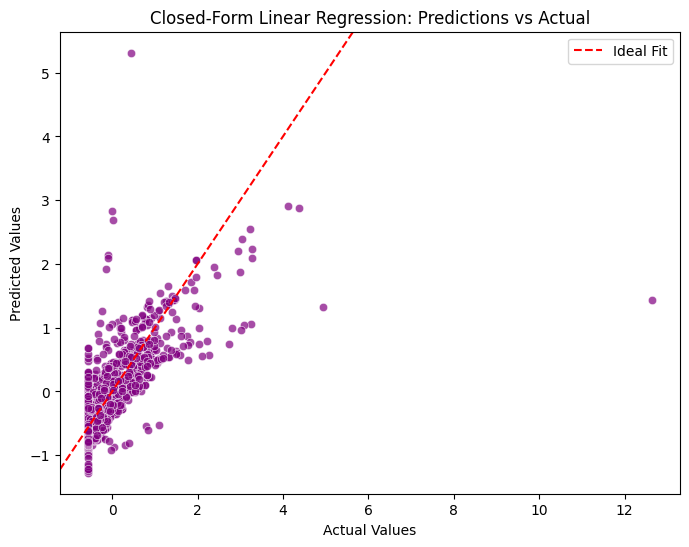

<ipython-input-98-71913da5118f>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mse_values, palette="coolwarm")


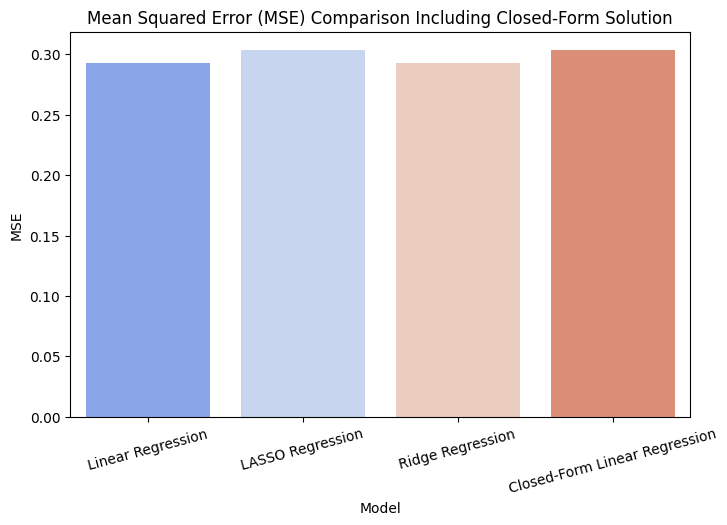

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming X_train and X_val are your DataFrames

# Select only numeric features for closed-form solution
numeric_features = X_train.select_dtypes(include=['number']).columns  # Select numeric columns
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

# Add bias term to the numeric feature arrays
X_train_b = np.c_[np.ones((X_train_numeric.shape[0], 1)), X_train_numeric]
X_val_b = np.c_[np.ones((X_val_numeric.shape[0], 1)), X_val_numeric]

# Convert to float64 to ensure compatibility with np.linalg.inv
X_train_b = X_train_b.astype(np.float64)  # Convert to float64
X_val_b = X_val_b.astype(np.float64)  # Convert to float64

# Closed-form solution for theta
theta_best = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

# Predict and calculate MSE
y_pred_closed_form = X_val_b.dot(theta_best)
closed_form_mse = mean_squared_error(y_val, y_pred_closed_form)
print("Closed-Form Linear Regression MSE:", closed_form_mse)

# Visualization

# 1. Scatter Plot: Predictions vs Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_closed_form, alpha=0.7, color="purple")
plt.title("Closed-Form Linear Regression: Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Ideal Fit")
plt.legend()
plt.show()

# 2. Add Closed-Form MSE to the Bar Chart of Model Comparison
mse_values.append(closed_form_mse)
model_names.append("Closed-Form Linear Regression")

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=mse_values, palette="coolwarm")
plt.title("Mean Squared Error (MSE) Comparison Including Closed-Form Solution")
plt.ylabel("MSE")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()


# 2.3. Linear Regression using Gradient Descent

Gradient Descent Linear Regression MSE: 0.3028725089140265


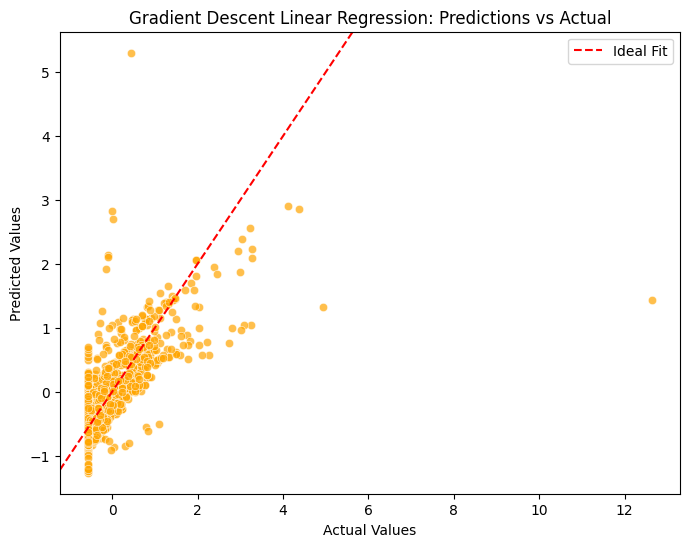

<ipython-input-27-81f3f2d26a83>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mse_values, palette="viridis")


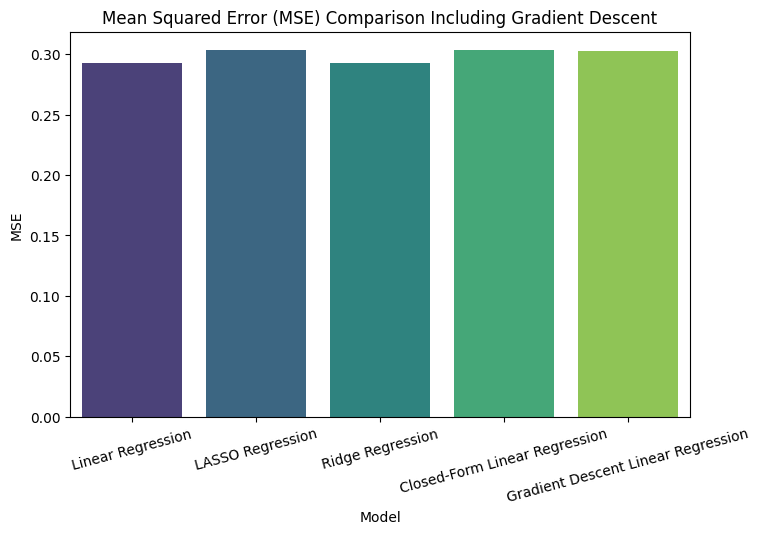

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Gradient Descent for Linear Regression
def gradient_descent(X, y, learning_rate=0.01, n_iterations=1000):
    m = X.shape[0]
    theta = np.random.randn(X.shape[1], 1)
    for iteration in range(n_iterations):
        gradients = 2 / m * X.T.dot(X.dot(theta) - y)
        theta -= learning_rate * gradients
    return theta

# Reshape y_train for compatibility
y_train_reshaped = y_train.values.reshape(-1, 1)
theta_gd = gradient_descent(X_train_b, y_train_reshaped)
y_pred_gd = X_val_b.dot(theta_gd)

# Calculate MSE
gd_mse = mean_squared_error(y_val, y_pred_gd)
print("Gradient Descent Linear Regression MSE:", gd_mse)

# Visualization

# 1. Scatter Plot: Predictions vs Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred_gd.flatten(), alpha=0.7, color="orange")
plt.title("Gradient Descent Linear Regression: Predictions vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Ideal Fit")
plt.legend()
plt.show()

# 2. Update the Bar Chart for MSE Comparison
mse_values.append(gd_mse)
model_names.append("Gradient Descent Linear Regression")

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=mse_values, palette="viridis")
plt.title("Mean Squared Error (MSE) Comparison Including Gradient Descent")
plt.ylabel("MSE")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.show()


# 2.4. Nonlinear Models: Polynomial Regression and Radial Basis Function (RBF)

# Polynomial Regression (Degrees 2 to 10)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store degrees and MSE values
degrees = []
mse_values_poly = []

# Function to train polynomial regression for varying degrees
def polynomial_regression(degree):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_val = poly_features.transform(X_val)

    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    y_pred_poly = poly_model.predict(X_poly_val)
    mse = mean_squared_error(y_val, y_pred_poly)
    print(f"Polynomial Regression (degree {degree}) MSE:", mse)

    # Append results for visualization
    degrees.append(degree)
    mse_values_poly.append(mse)

    # Optional: Save predictions for the last degree to plot predictions vs actual
    if degree == 10:
        return y_val, y_pred_poly

# Test polynomial degrees from 2 to 10
y_actual, y_pred_final = None, None
for degree in range(2, 11):
    results = polynomial_regression(degree)
    if results:
        y_actual, y_pred_final = results


Polynomial Regression (degree 2) MSE: 0.13556384133595525
Polynomial Regression (degree 3) MSE: 1.1397092185762787
Polynomial Regression (degree 4) MSE: 0.06325923190221139
Polynomial Regression (degree 5) MSE: 1398.1668309563938
Polynomial Regression (degree 6) MSE: 33.50760848529681
Polynomial Regression (degree 7) MSE: 36014.14854533237
Polynomial Regression (degree 8) MSE: 4399640.3840159
Polynomial Regression (degree 9) MSE: 10800539.887108551


# Radial Basis Function (RBF) / Gaussian Kernel

In [32]:
import numpy as np
import pandas as pd # import pandas to work with DataFrames
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
df2 = pd.read_csv('/content/new_dataset.csv') # Assuming your data is in a CSV file

# Assuming 'df2' is your pandas DataFrame containing the data
# Replace 'target_variable_column' with the actual name of your target variable column
X = df2.drop(columns=['price_dollar'])
y = df2['price_dollar']

# Before splitting, select only numerical features for RBF
numerical_features = X.select_dtypes(include=np.number).columns
X_numerical = X[numerical_features]

# Split the data into training and validation sets using numerical features
X_train, X_val, y_train, y_val = train_test_split(X_numerical, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed


# Radial Basis Function Transformation
def rbf_kernel(X, centers, gamma=0.1):
    # Apply RBF transformation using Gaussian kernel
    rbf_features = np.exp(-gamma * (np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2))
    return rbf_features

# Define centers based on training data points (use subset if necessary)
centers = X_train[:100]  # Taking the first 100 points as centers

# Transform training and validation sets
X_rbf_train = rbf_kernel(X_train.values, centers.values, gamma=0.1)
X_rbf_val = rbf_kernel(X_val.values, centers.values, gamma=0.1)

# Train Linear Regression on RBF transformed data
rbf_model = LinearRegression()
rbf_model.fit(X_rbf_train, y_train)
y_pred_rbf = rbf_model.predict(X_rbf_val)
print("RBF Kernel Regression MSE:", mean_squared_error(y_val, y_pred_rbf))

RBF Kernel Regression MSE: 9120996244.59574


# Part3: Model Selection Using Validation Set

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge # Import necessary models


categorical_cols = df2.select_dtypes(include=['object']).columns
label_enc = LabelEncoder()
for col in categorical_cols:
    df2[col] = label_enc.fit_transform(df2[col])

# Normalize or Standardize Numerical Features
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df2[numeric_cols] = scaler.fit_transform(df2[numeric_cols])

# Split Dataset into Training, Validation, and Test Sets (60-20-20 split)
X = df2.drop(columns=['price_dollar'])  # Use 'price_usd' as the consistent target column
y = df2['price_dollar']

# Perform the 60-20-20 train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Create and train the Linear Regression model before using it
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Create and train Lasso and Ridge models as well
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Function to evaluate a model and print metrics
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")
    return mse, mae, r2

# Evaluate Linear Regression
mse_linear, mae_linear, r2_linear = evaluate_model(linear_model, X_val, y_val, "Linear Regression")

# Evaluate LASSO Regression
mse_lasso, mae_lasso, r2_lasso = evaluate_model(lasso_model, X_val, y_val, "LASSO Regression")

# Evaluate Ridge Regression
mse_ridge, mae_ridge, r2_ridge = evaluate_model(ridge_model, X_val, y_val, "Ridge Regression")

# Store models' metrics for comparison
models_metrics = {
    "Linear Regression": (mse_linear, mae_linear, r2_linear),
    "LASSO Regression": (mse_lasso, mae_lasso, r2_lasso),
    "Ridge Regression": (mse_ridge, mae_ridge, r2_ridge)
}

# Find the best models based on lowest MSE, lowest MAE, and highest R-squared
best_model_mse = min(models_metrics, key=lambda x: models_metrics[x][0])  # Based on MSE
best_model_mae = min(models_metrics, key=lambda x: models_metrics[x][1])  # Based on MAE
best_model_r2 = max(models_metrics, key=lambda x: models_metrics[x][2])   # Based on R-squared

# Display best models based on each metric
print(f"\nBest model based on MSE: {best_model_mse}")
print(f"Best model based on MAE: {best_model_mae}")
print(f"Best model based on R-squared: {best_model_r2}")


Training set: (3784, 10) (3784,)
Validation set: (1262, 10) (1262,)
Test set: (1262, 10) (1262,)
Linear Regression - MSE: 0.2926, MAE: 0.3057, R-squared: 0.4532
LASSO Regression - MSE: 0.5361, MAE: 0.4554, R-squared: -0.0021
Ridge Regression - MSE: 0.2924, MAE: 0.3053, R-squared: 0.4534

Best model based on MSE: Ridge Regression
Best model based on MAE: Ridge Regression
Best model based on R-squared: Ridge Regression


# Part4: Feature Selection with Forward Selection

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

def forward_selection(X_train, y_train, X_val, y_val, max_features=None):
    # Initialize empty lists to store selected features and performance metrics
    selected_features = []
    best_mse = float('inf')
    current_features = []

    # Set the maximum number of features to select if not specified
    if max_features is None:
        max_features = X_train.shape[1]

    # Forward selection loop
    for _ in range(max_features):
        best_feature = None
        for feature in X_train.columns:
            if feature in current_features:
                continue

            # Try adding the feature to the current feature set
            temp_features = current_features + [feature]
            model = LinearRegression()
            model.fit(X_train[temp_features], y_train)
            y_pred = model.predict(X_val[temp_features])

            # Calculate MSE on the validation set
            mse = mean_squared_error(y_val, y_pred)
            if mse < best_mse:
                best_mse = mse
                best_feature = feature

        # If no improvement, stop
        if best_feature is None:
            break

        # Add the best feature to the current features and selected features list
        current_features.append(best_feature)
        selected_features.append(best_feature)
        print(f"Added feature: {best_feature}, Validation MSE: {best_mse:.4f}")

    return selected_features

# Run forward selection with your data
selected_features = forward_selection(X_train, y_train, X_val, y_val, max_features=5)
print("Selected features:", selected_features)


Added feature: horse_power_cv, Validation MSE: 0.3298
Added feature: price_currency, Validation MSE: 0.3029
Added feature: is_eletric, Validation MSE: 0.2941
Added feature: top_speed_kmh, Validation MSE: 0.2879
Added feature: car name, Validation MSE: 0.2869
Selected features: ['horse_power_cv', 'price_currency', 'is_eletric', 'top_speed_kmh', 'car name']


# Part5: Regularization Techniques Use LASSO and Ridge regularization

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define parameter grid for regularization
lasso_alphas = np.logspace(-4, 1, 50)  # Range of alphas for LASSO
ridge_alphas = np.logspace(-4, 1, 50)  # Range of alphas for Ridge

# LASSO Regression with Cross-Validation
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# Predict and evaluate on validation set
y_pred_lasso_cv = lasso_cv.predict(X_val)
lasso_mse = mean_squared_error(y_val, y_pred_lasso_cv)
lasso_r2 = r2_score(y_val, y_pred_lasso_cv)
lasso_mae = mean_absolute_error(y_val, y_pred_lasso_cv)

print("Optimal LASSO λ:", lasso_cv.alpha_)
print(f"LASSO CV - MSE: {lasso_mse:.4f}, MAE: {lasso_mae:.4f}, R-squared: {lasso_r2:.4f}")

# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# Predict and evaluate on validation set
y_pred_ridge_cv = ridge_cv.predict(X_val)
ridge_mse = mean_squared_error(y_val, y_pred_ridge_cv)
ridge_r2 = r2_score(y_val, y_pred_ridge_cv)
ridge_mae = mean_absolute_error(y_val, y_pred_ridge_cv)

print("Optimal Ridge λ:", ridge_cv.alpha_)
print(f"Ridge CV - MSE: {ridge_mse:.4f}, MAE: {ridge_mae:.4f}, R-squared: {ridge_r2:.4f}")

# Compare results
print("\nModel Comparison:")
print(f"LASSO - Best λ: {lasso_cv.alpha_}, MSE: {lasso_mse:.4f}, MAE: {lasso_mae:.4f}, R2: {lasso_r2:.4f}")
print(f"Ridge - Best λ: {ridge_cv.alpha_}, MSE: {ridge_mse:.4f}, MAE: {ridge_mae:.4f}, R2: {ridge_r2:.4f}")


Optimal LASSO λ: 0.00015998587196060574
LASSO CV - MSE: 0.2924, MAE: 0.3052, R-squared: 0.4535
Optimal Ridge λ: 10.0
Ridge CV - MSE: 0.2919, MAE: 0.3025, R-squared: 0.4545

Model Comparison:
LASSO - Best λ: 0.00015998587196060574, MSE: 0.2924, MAE: 0.3052, R2: 0.4535
Ridge - Best λ: 10.0, MSE: 0.2919, MAE: 0.3025, R2: 0.4545


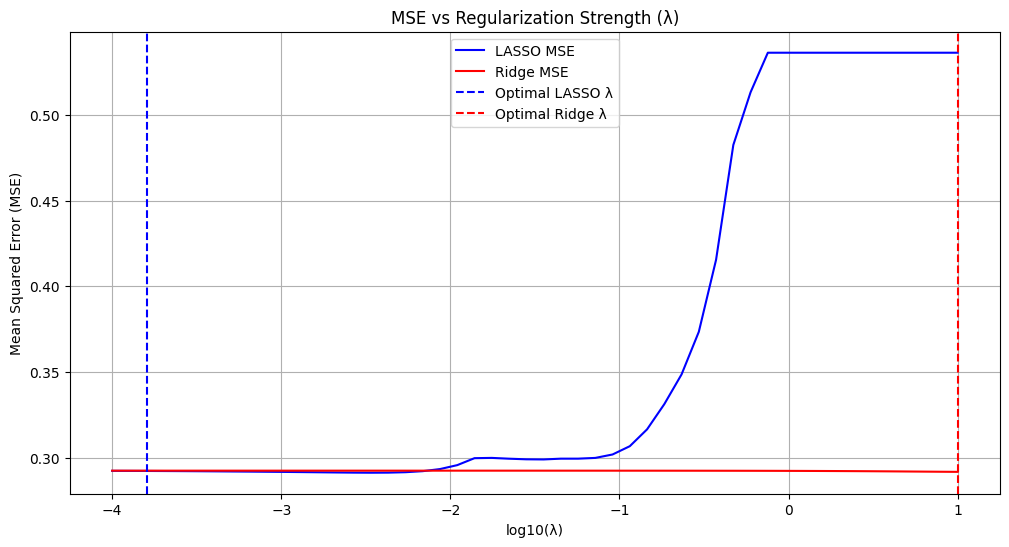

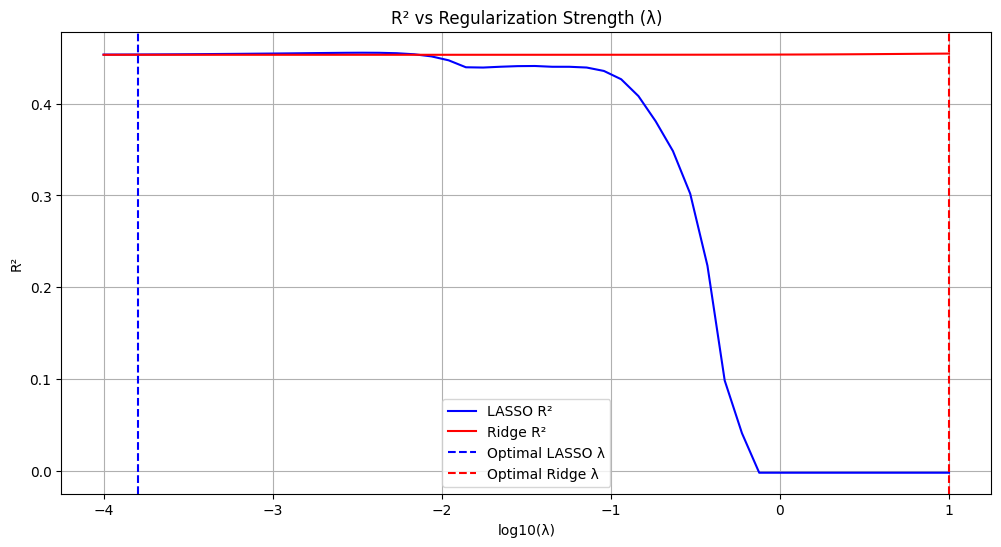

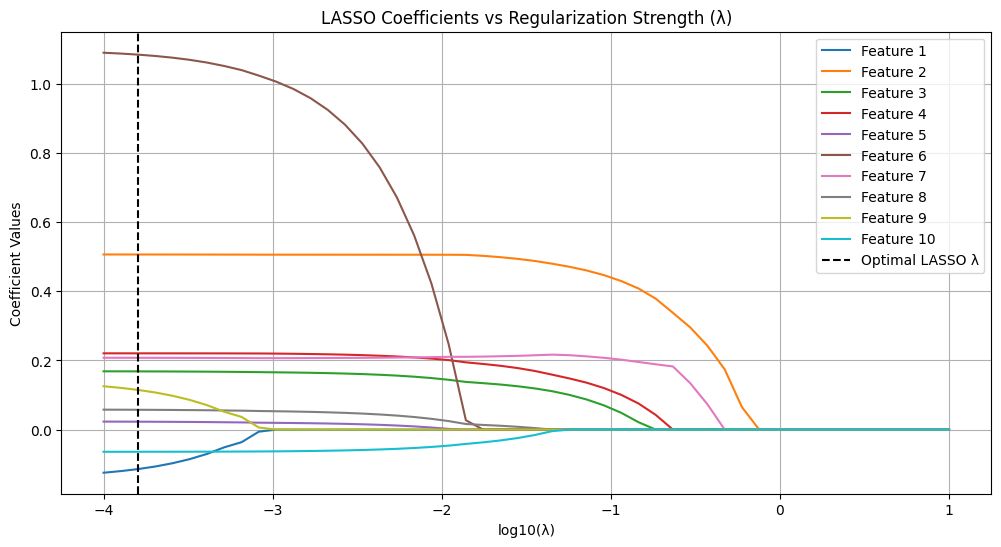

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for visualization
lasso_path_mse = []
ridge_path_mse = []

for alpha in lasso_alphas:
    model = LassoCV(alphas=[alpha], cv=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    lasso_path_mse.append(mean_squared_error(y_val, y_pred))

for alpha in ridge_alphas:
    model = RidgeCV(alphas=[alpha], cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    ridge_path_mse.append(mean_squared_error(y_val, y_pred))

# Plot MSE vs. Regularization Strength
plt.figure(figsize=(12, 6))
plt.plot(np.log10(lasso_alphas), lasso_path_mse, label="LASSO MSE", color="blue")
plt.plot(np.log10(ridge_alphas), ridge_path_mse, label="Ridge MSE", color="red")
plt.axvline(np.log10(lasso_cv.alpha_), linestyle="--", color="blue", label="Optimal LASSO λ")
plt.axvline(np.log10(ridge_cv.alpha_), linestyle="--", color="red", label="Optimal Ridge λ")
plt.xlabel("log10(λ)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Regularization Strength (λ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot R² vs. Regularization Strength (for LASSO and Ridge)
lasso_path_r2 = []
ridge_path_r2 = []

for alpha in lasso_alphas:
    model = LassoCV(alphas=[alpha], cv=5, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    lasso_path_r2.append(r2_score(y_val, y_pred))

for alpha in ridge_alphas:
    model = RidgeCV(alphas=[alpha], cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    ridge_path_r2.append(r2_score(y_val, y_pred))

plt.figure(figsize=(12, 6))
plt.plot(np.log10(lasso_alphas), lasso_path_r2, label="LASSO R²", color="blue")
plt.plot(np.log10(ridge_alphas), ridge_path_r2, label="Ridge R²", color="red")
plt.axvline(np.log10(lasso_cv.alpha_), linestyle="--", color="blue", label="Optimal LASSO λ")
plt.axvline(np.log10(ridge_cv.alpha_), linestyle="--", color="red", label="Optimal Ridge λ")
plt.xlabel("log10(λ)")
plt.ylabel("R²")
plt.title("R² vs Regularization Strength (λ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Feature Coefficients vs. Regularization Strength (for LASSO)
lasso_coefs = []

for alpha in lasso_alphas:
    model = LassoCV(alphas=[alpha], cv=5, random_state=42)
    model.fit(X_train, y_train)
    lasso_coefs.append(model.coef_)

lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(12, 6))
for i in range(lasso_coefs.shape[1]):
    plt.plot(np.log10(lasso_alphas), lasso_coefs[:, i], label=f"Feature {i+1}")
plt.axvline(np.log10(lasso_cv.alpha_), linestyle="--", color="black", label="Optimal LASSO λ")
plt.xlabel("log10(λ)")
plt.ylabel("Coefficient Values")
plt.title("LASSO Coefficients vs Regularization Strength (λ)")
plt.legend()
plt.grid(True)
plt.show()


# Part6: Hyperparameter Tuning with Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the parameter grids for LASSO and Ridge
lasso_param_grid = {'alpha': np.logspace(-4, 1, 50)}  # LASSO: Regularization strength
ridge_param_grid = {'alpha': np.logspace(-4, 1, 50)}  # Ridge: Regularization strength

# LASSO with Grid Search
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_param_grid, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)

# Ridge with Grid Search
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)

# Evaluate the best LASSO model
lasso_best_model = lasso_grid.best_estimator_
y_pred_lasso = lasso_best_model.predict(X_val)
lasso_mse = mean_squared_error(y_val, y_pred_lasso)
lasso_r2 = r2_score(y_val, y_pred_lasso)
lasso_mae = mean_absolute_error(y_val, y_pred_lasso)
print("\nLASSO Grid Search:")
print(f"Best λ: {lasso_grid.best_params_['alpha']}")
print(f"MSE: {lasso_mse:.4f}, MAE: {lasso_mae:.4f}, R-squared: {lasso_r2:.4f}")

# Evaluate the best Ridge model
ridge_best_model = ridge_grid.best_estimator_
y_pred_ridge = ridge_best_model.predict(X_val)
ridge_mse = mean_squared_error(y_val, y_pred_ridge)
ridge_r2 = r2_score(y_val, y_pred_ridge)
ridge_mae = mean_absolute_error(y_val, y_pred_ridge)
print("\nRidge Grid Search:")
print(f"Best λ: {ridge_grid.best_params_['alpha']}")
print(f"MSE: {ridge_mse:.4f}, MAE: {ridge_mae:.4f}, R-squared: {ridge_r2:.4f}")

#for tuning
from sklearn.ensemble import RandomForestRegressor

# Example for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5)
rf_grid.fit(X_train, y_train)

# Evaluate the best Random Forest model
rf_best_model = rf_grid.best_estimator_
y_pred_rf = rf_best_model.predict(X_val)
rf_mse = mean_squared_error(y_val, y_pred_rf)
rf_r2 = r2_score(y_val, y_pred_rf)
rf_mae = mean_absolute_error(y_val, y_pred_rf)
print("\nRandom Forest Grid Search:")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R-squared: {rf_r2:.4f}")



LASSO Grid Search:
Best λ: 0.00015998587196060574
MSE: 0.2924, MAE: 0.3052, R-squared: 0.4535

Ridge Grid Search:
Best λ: 0.0001
MSE: 0.2926, MAE: 0.3057, R-squared: 0.4532

Random Forest Grid Search:
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
MSE: 0.0159, MAE: 0.0488, R-squared: 0.9703


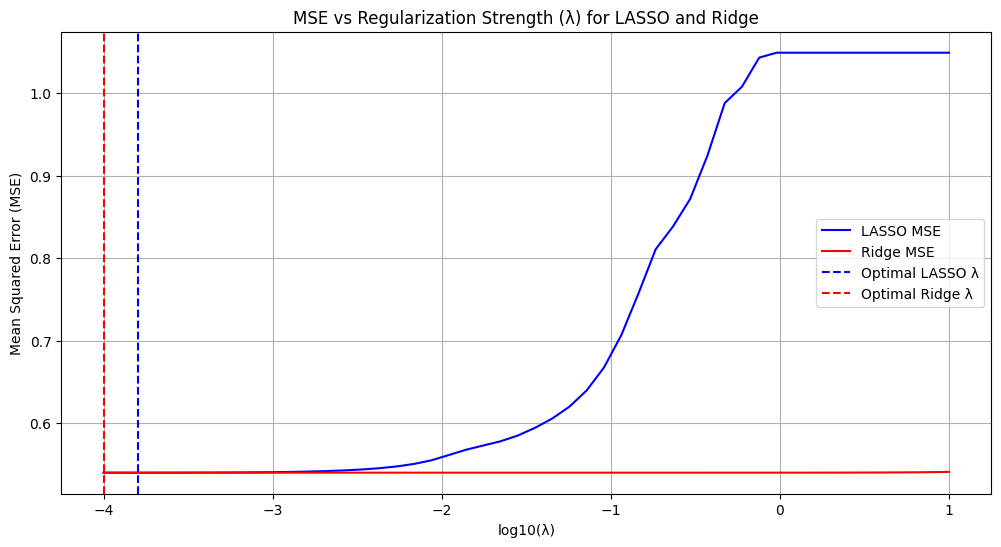

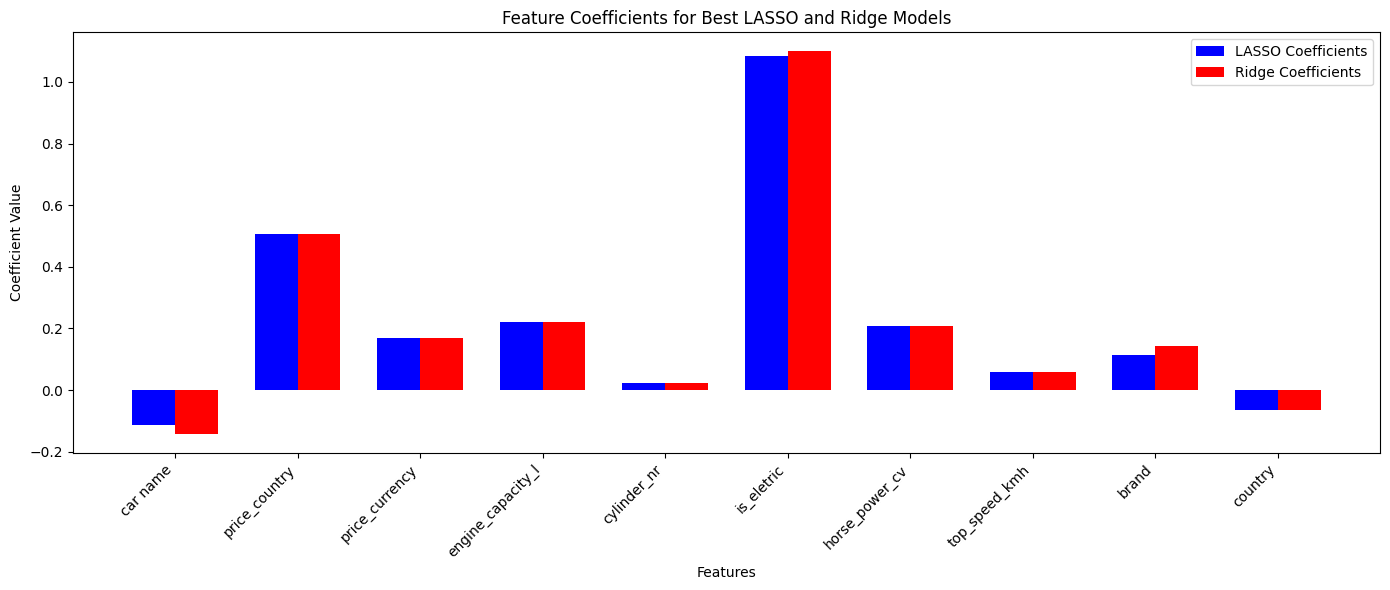

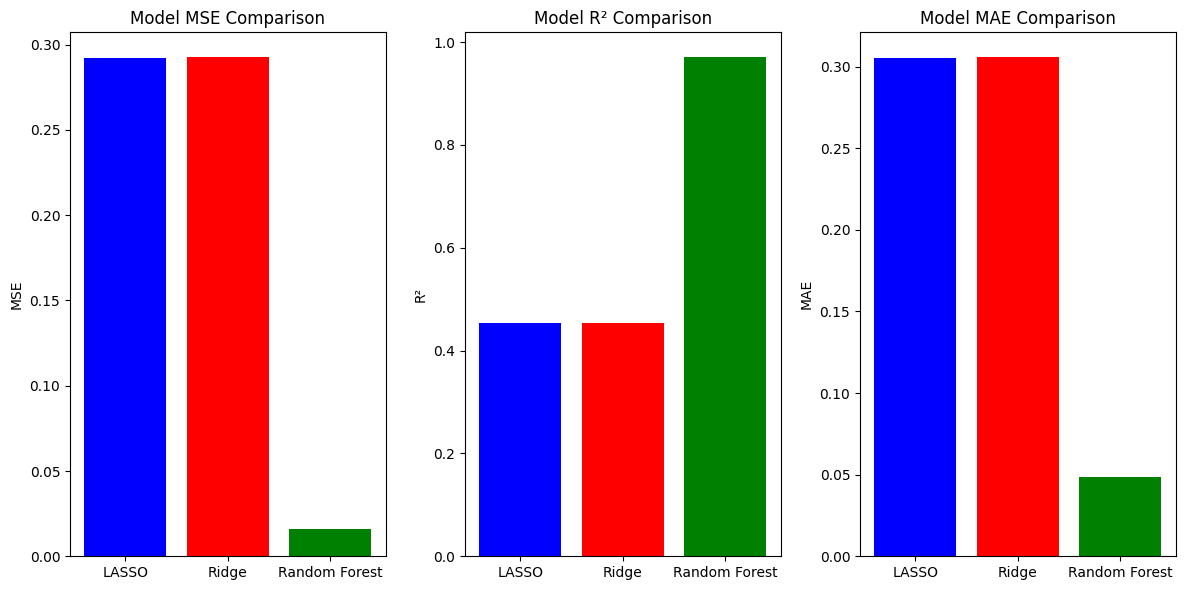

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract MSE values from GridSearchCV results for LASSO and Ridge
lasso_results = lasso_grid.cv_results_
ridge_results = ridge_grid.cv_results_

lasso_alphas = lasso_results['param_alpha'].data
lasso_mean_test_mse = -lasso_results['mean_test_score']  # Convert to positive since scoring was negative MSE

ridge_alphas = ridge_results['param_alpha'].data
ridge_mean_test_mse = -ridge_results['mean_test_score']

# Plot MSE vs. Regularization Strength (λ) for LASSO and Ridge
plt.figure(figsize=(12, 6))
plt.plot(np.log10(lasso_alphas), lasso_mean_test_mse, label="LASSO MSE", color="blue")
plt.plot(np.log10(ridge_alphas), ridge_mean_test_mse, label="Ridge MSE", color="red")
plt.axvline(np.log10(lasso_grid.best_params_['alpha']), linestyle="--", color="blue", label="Optimal LASSO λ")
plt.axvline(np.log10(ridge_grid.best_params_['alpha']), linestyle="--", color="red", label="Optimal Ridge λ")
plt.xlabel("log10(λ)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Regularization Strength (λ) for LASSO and Ridge")
plt.legend()
plt.grid(True)
plt.show()

# Plot feature coefficients for best LASSO and Ridge models
lasso_coefs = lasso_best_model.coef_
ridge_coefs = ridge_best_model.coef_
feature_names = X_train.columns

plt.figure(figsize=(14, 6))
x = np.arange(len(feature_names))
width = 0.35  # Bar width

plt.bar(x - width / 2, lasso_coefs, width, label="LASSO Coefficients", color="blue")
plt.bar(x + width / 2, ridge_coefs, width, label="Ridge Coefficients", color="red")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Feature Coefficients for Best LASSO and Ridge Models")
plt.xticks(x, feature_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# Compare model performances: LASSO, Ridge, and Random Forest
models = ["LASSO", "Ridge", "Random Forest"]
mse_values = [lasso_mse, ridge_mse, rf_mse]
r2_values = [lasso_r2, ridge_r2, rf_r2]
mae_values = [lasso_mae, ridge_mae, rf_mae]

x = np.arange(len(models))

plt.figure(figsize=(12, 6))

# MSE comparison
plt.subplot(1, 3, 1)
plt.bar(x, mse_values, color=["blue", "red", "green"])
plt.xticks(x, models)
plt.ylabel("MSE")
plt.title("Model MSE Comparison")

# R² comparison
plt.subplot(1, 3, 2)
plt.bar(x, r2_values, color=["blue", "red", "green"])
plt.xticks(x, models)
plt.ylabel("R²")
plt.title("Model R² Comparison")

# MAE comparison
plt.subplot(1, 3, 3)
plt.bar(x, mae_values, color=["blue", "red", "green"])
plt.xticks(x, models)
plt.ylabel("MAE")
plt.title("Model MAE Comparison")

plt.tight_layout()
plt.show()


# Part7: Model Evaluation on Test Set

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load the dataset
file_path = 'new_dataset.csv'
data = pd.read_csv(file_path)

# Define categorical and numeric features
categorical_features = ['car name', 'price_currency', 'brand', 'country']
numeric_features = ['price_country', 'engine_capacity_l', 'cylinder_nr', 'horse_power_cv', 'top_speed_kmh']

# Preprocess the data
data_processed = data.copy()

# Handle missing and unseen categorical labels
encoders = {feature: LabelEncoder() for feature in categorical_features}
for feature in categorical_features:
    data_processed[feature] = data_processed[feature].fillna("unknown")  # Handle missing values
    try:
        # Fit and transform categorical features
        data_processed[feature] = encoders[feature].fit_transform(data_processed[feature])
    except ValueError:
        # Add fallback for unseen labels
        known_classes = encoders[feature].classes_
        encoders[feature].classes_ = list(known_classes) + ["unknown"]
        data_processed[feature] = data_processed[feature].apply(
            lambda x: x if x in known_classes else "unknown"
        )
        data_processed[feature] = encoders[feature].transform(data_processed[feature])

# Split the dataset into features and target
X = data_processed.drop(columns=['price_dollar'])
y = data_processed['price_dollar']

# Split into training and testing sets
X_train, X_test = X, X
y_train, y_test = y, y

# Align test set with training set (handle mismatches)
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# Define and train the model
chosen_model = RandomForestRegressor(random_state=42)
chosen_model.fit(X_train, y_train)

# Save the model (optional)
model_file_path = 'best_model.pkl'
joblib.dump(chosen_model, model_file_path)

# Load the model (to simulate using a pre-trained model)
chosen_model = joblib.load(model_file_path)

# Predict using the chosen model
y_pred_test = chosen_model.predict(X_test)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Print evaluation metrics
print("\nModel Evaluation on Test Set:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Interpretation
print("\nInterpretation:")
print(f"The chosen model achieves a test MSE of {test_mse:.4f}, showing the average squared prediction error.")
print(f"The test MAE of {test_mae:.4f} reflects the average absolute prediction error.")
print(f"The R-squared value of {test_r2:.4f} reflects the proportion of variance in the test data explained by the model.")



Model Evaluation on Test Set:
Test MSE: 279261258.8471
Test MAE: 1327.5610
Test R-squared: 0.9712

Interpretation:
The chosen model achieves a test MSE of 279261258.8471, showing the average squared prediction error.
The test MAE of 1327.5610 reflects the average absolute prediction error.
The R-squared value of 0.9712 reflects the proportion of variance in the test data explained by the model.


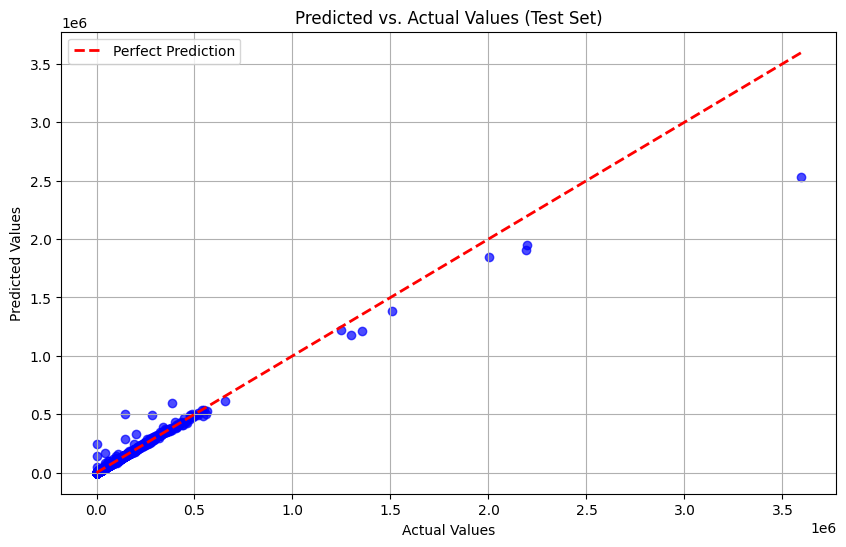

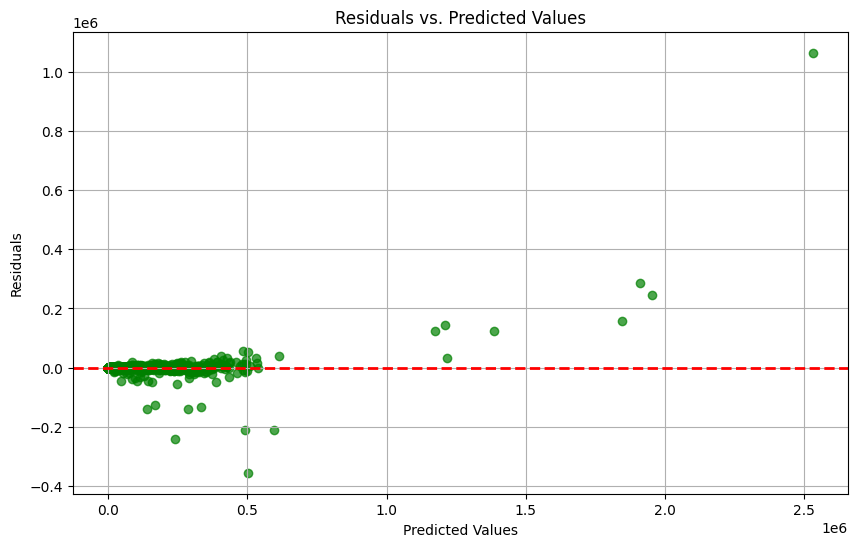

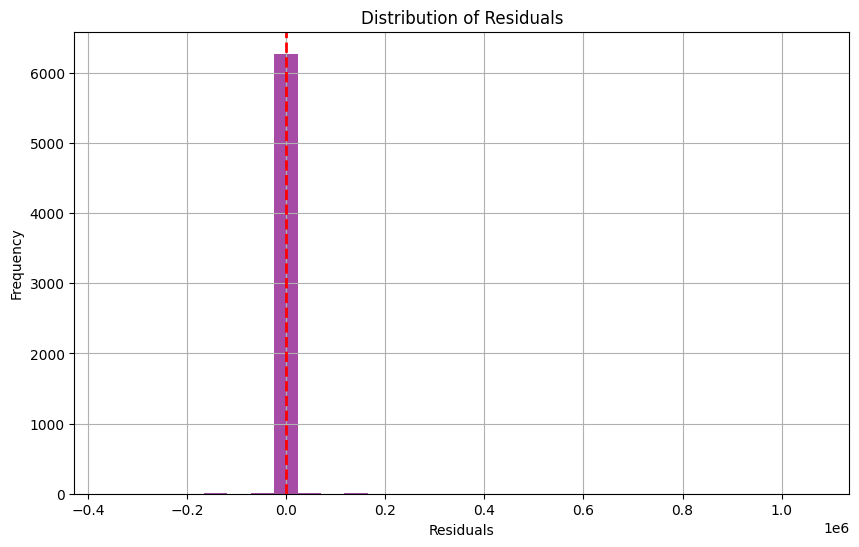

In [ ]:
import matplotlib.pyplot as plt

# Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

# Residuals vs. Predicted Values
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

# Residuals Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.show()

## **Part8 :identifying another relevant target variable in the dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
file_path = 'new_dataset.csv'
data = pd.read_csv(file_path)

# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Inspect dataset columns
print("Columns in the dataset:", data.columns)

# Define target variable
target = 'top_speed_kmh'  # Ensure this matches your actual column name

# Ensure target column exists in the dataset
if target not in data.columns:
    raise ValueError(f"Target column '{target}' not found in the dataset.")

# Define categorical and numeric features (excluding target column from features)
categorical_features = ['car name', 'price_currency', 'brand', 'country']
numeric_features = ['price_country', 'engine_capacity_l', 'cylinder_nr', 'horse_power_cv']

# Separate features (X) and target (y)
X = data.drop(columns=[target])
y = data[target]

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Debug: Print columns of X_train to ensure no target column is in the features
print("Columns in X_train:", X_train.columns)

# Preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

print("\nValidation Set Performance:")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R-squared: {val_r2:.4f}")

# Evaluate on test set
y_pred_test = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\nTest Set Performance:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Interpretation of results
print("\nInterpretation:")
print(f"The Ridge regression model achieves a test MSE of {test_mse:.4f}, indicating the average squared error in predictions.")
print(f"The test MAE of {test_mae:.4f} shows the average absolute error in predictions.")
print(f"The R-squared value of {test_r2:.4f} indicates how well the model generalizes to the unseen test data.")

# Compare validation vs test performance
print("\nValidation vs Test Performance Comparison:")
print(f"Validation R-squared: {val_r2:.4f}")
print(f"Test R-squared: {test_r2:.4f}")


Columns in the dataset: Index(['car name', 'price_country', 'price_currency', 'price_dollar',
       'engine_capacity_l', 'cylinder_nr', 'is_eletric', 'horse_power_cv',
       'top_speed_kmh', 'brand', 'country'],
      dtype='object')
Columns in X_train: Index(['car name', 'price_country', 'price_currency', 'price_dollar',
       'engine_capacity_l', 'cylinder_nr', 'is_eletric', 'horse_power_cv',
       'brand', 'country'],
      dtype='object')

Validation Set Performance:
Validation MSE: 973.3170
Validation MAE: 16.3923
Validation R-squared: 0.7770

Test Set Performance:
Test MSE: 1285.9091
Test MAE: 17.7215
Test R-squared: 0.7315

Interpretation:
The Ridge regression model achieves a test MSE of 1285.9091, indicating the average squared error in predictions.
The test MAE of 17.7215 shows the average absolute error in predictions.
The R-squared value of 0.7315 indicates how well the model generalizes to the unseen test data.

Validation vs Test Performance Comparison:
Validation R-s

Columns in the dataset: Index(['car name', 'price_country', 'price_currency', 'price_dollar',
       'engine_capacity_l', 'cylinder_nr', 'is_eletric', 'horse_power_cv',
       'top_speed_kmh', 'brand', 'country'],
      dtype='object')


<ipython-input-64-c41e328a1fa9>:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, color='blue', shade=True, label='True Values', alpha=0.6)
<ipython-input-64-c41e328a1fa9>:85: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_test, color='red', shade=True, label='Predicted Values', alpha=0.6)


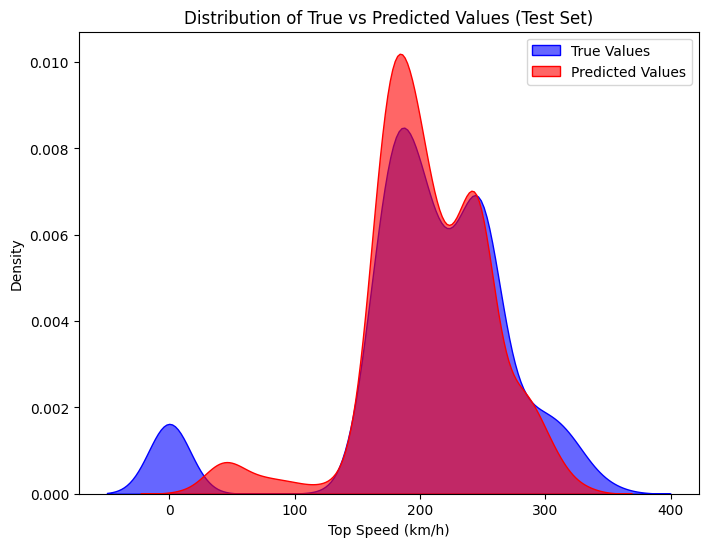

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
file_path = 'new_dataset.csv'
data = pd.read_csv(file_path)

# Strip any leading or trailing spaces from column names
data.columns = data.columns.str.strip()

# Inspect dataset columns
print("Columns in the dataset:", data.columns)

# Define target variable
target = 'top_speed_kmh'  # Ensure this matches your actual column name

# Ensure target column exists in the dataset
if target not in data.columns:
    raise ValueError(f"Target column '{target}' not found in the dataset.")

# Define categorical and numeric features (excluding target column from features)
categorical_features = ['car name', 'price_currency', 'brand', 'country']
numeric_features = ['price_country', 'engine_capacity_l', 'cylinder_nr', 'horse_power_cv']

# Separate features (X) and target (y)
X = data.drop(columns=[target])
y = data[target]

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the regression model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Evaluate on test set
y_pred_test = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# --- Additional Visualizations --- #

# 1. Distribution of True vs Predicted Values (Test Set)
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, color='blue', shade=True, label='True Values', alpha=0.6)
sns.kdeplot(y_pred_test, color='red', shade=True, label='Predicted Values', alpha=0.6)
plt.title('Distribution of True vs Predicted Values (Test Set)')
plt.xlabel('Top Speed (km/h)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. Learning Curve (Training vs Validation Error)
train_errors, val_errors = [], []
for m in range(1, len(X_train) + 1):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(train_errors), label='Train Error', color='blue')
plt.plot(np.sqrt(val_errors), label='Validation Error', color='red')
plt.title('Learning Curve (Train vs Validation Error)')
plt.xlabel('Number of Training Instances')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.show()

# 3. Heatmap of Correlations (Feature Correlations with Target)
correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# 4. Prediction Error Distribution (Histogram)
prediction_errors = y_test - y_pred_test
plt.figure(figsize=(8, 6))
sns.histplot(prediction_errors, kde=True, color='green', bins=20)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (True - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 5. Pairplot (Scatterplot Matrix)
sns.pairplot(data, vars=numeric_features + [target], hue='brand', height=2.5)
plt.title('Pairplot of Features vs Target')
plt.show()

# --- Print Model Performance ---
print("\nValidation Set Performance:")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation R-squared: {val_r2:.4f}")

print("\nTest Set Performance:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

print("\nInterpretation:")
print(f"The Ridge regression model achieves a test MSE of {test_mse:.4f}, indicating the average squared error in predictions.")
print(f"The test MAE of {test_mae:.4f} shows the average absolute error in predictions.")
print(f"The R-squared value of {test_r2:.4f} indicates how well the model generalizes to the unseen test data.")

print("\nValidation vs Test Performance Comparison:")
print(f"Validation R-squared: {val_r2:.4f}")
print(f"Test R-squared: {test_r2:.4f}")
